### Numerical Experiments

6 different datasets are used with ids [31, 1464, 334, 333, 1504]
The different optimizers for sparse grid optimization are compared

In [4]:
import openml

from openml import tasks

import HPO

import pysgpp

import sys

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn.metrics

from sklearn.model_selection import cross_val_score

import numpy as np
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor, KerasClassifier


def to_standard(lower, upper, value):
    return (value-lower)/(upper-lower)


def from_standard(lower, upper, value):
    return value*(upper-lower)+lower

BUDGET = 20
VERBOSE = 0
CV = 2
SCORING = 'neg_mean_squared_error'
TESTING = False

DATASETS = []

hyperparameterspace = {
    'loss': ["list", 'binary_crossentropy', 'categorical_crossentropy', 'binary_crossentropy', 'mean_absolute_error'],
    #'loss': ["list", 'mean_absolute_error', 'log_cosh'],
    'epochs': ["interval-int", 1, 100]
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste

ids = [31, 1464, 334, 333]#, 1504]

In [5]:

RESULTS_datasets = [[] for _ in range(len(ids))]

for i in range(len(ids)):

    DATASETS.append(str(ids[i]))
    
    # Get dataset by ID
    dataset = openml.datasets.get_dataset(ids[i])

    # Get the data itself as a dataframe (or otherwise)
    data, _, _, _ = dataset.get_data(dataset_format="array")

    X = torch.Tensor([x[:-1] for x in data])
    Y = torch.Tensor([[x[-1]] for x in data])
    
    dataset = HPO.Dataset(X, Y)

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(2)


        def eval(self, x):
            index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            loss = hyperparameterspace_special["loss"][index]
            epochs = int(from_standard(1, 400, x[1]))
            
            # Function to create model, required for KerasClassifier
            def create_model():
                # create model
                model = Sequential()
                model.add(Dense(30, input_shape=(len(dataset.get_X()[0]),), activation='relu'))
                model.add(Dense(20, activation='relu'))
                model.add(Dense(30, activation='relu'))
                model.add(Dense(len(dataset.get_Y()[0]), activation=None))
                # Compile model
                model.compile(loss=loss, optimizer='adam', metrics=['mean_squared_error'])
                return model

            model = KerasClassifier(model=create_model, verbose=0)

            # scores = cross_val_score(model, dataset.get_X(), dataset.get_Y(), cv=CV, scoring=SCORING)

            # return -scores.mean()

            model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs)

            if TESTING:
                Y_predicted = model.predict(dataset.get_X_test())
                if np.any(np.isnan(Y_predicted)):
                    return 1000
                return sklearn.metrics.accuracy_score(dataset.get_Y_test().tolist(), Y_predicted)
            else:
                Y_predicted = model.predict(dataset.get_X_validation())
                if np.any(np.isnan(Y_predicted)):
                    return 1000
                return sklearn.metrics.accuracy_score(dataset.get_Y_validation().tolist(), Y_predicted)
            

    available_optimizers = ["adaptive_gradient_descent", "adaptive_newton", "bfgs", "cmaes", "differential_evolution", "gradient_descent", "nlcg", "nelder_mead", "newton", "rprop"]

    results_temp = []
    results_opt_temp = []

    for j in range(len(available_optimizers)):
        print("Current optimizer:", j, available_optimizers[j])

        sparse_params=[3, 0.95, available_optimizers[j]]

        f = ExampleFunction()

        optimization = HPO.SparseGridSearchOptimization(dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=sparse_params[0], adaptivity=sparse_params[1], optimizer=sparse_params[2])

        result = optimization.fit()


        TESTING = True
        results_temp.append(f.eval(result[0]))
        results_temp.append(f.eval(result[1]))
        TESTING = False

    for m in range(len(results_temp)):
        RESULTS_datasets[i].append(results_temp[m])


Current optimizer: 0 adaptive_gradient_descent
Adaptive grid generation (Ritter-Novak)...
Done in 103694ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (adaptive gradient descent)...
Done in 0ms.
Current optimizer: 1 adaptive_newton
Adaptive grid generation (Ritter-Novak)...
Done in 102454ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (adaptive Newton)...
Done in 0ms.
Current optimizer: 2 bfgs
Adaptive grid generation (Ritter-Novak)...
Done in 103676ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (BFGS)...
Done in 0ms.
Current optimizer: 3 cmaes
Adaptive grid generation (Ritter-Novak)...
Done in 103430ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (CMA-ES)...
Done in 0ms.
Current optimizer: 4 differential_evolution
Adaptive grid generation (Ritter-Novak)...
Done in 104075ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (differential evolution)...
Done in 1ms.
Current

### Plotting

[[0.71, 0.29, 0.71, 0.29, 0.71, 0.29, 0.71, 0.29, 0.29, 0.71, 0.29, 0.29, 0.29, 0.71, 0.71, 0.71, 0.29, 0.29, 0.29, 0.29], [0.7866666666666666, 0.7866666666666666, 0.7866666666666666, 0.21333333333333335, 0.21333333333333335, 0.21333333333333335, 0.7866666666666666, 0.21333333333333335, 0.7866666666666666, 0.7866666666666666, 0.21333333333333335, 0.21333333333333335, 0.7866666666666666, 0.21333333333333335, 0.21333333333333335, 0.7866666666666666, 0.21333333333333335, 0.21333333333333335, 0.21333333333333335, 0.21333333333333335], [0.6859504132231405, 0.9834710743801653, 0.6859504132231405, 1.0, 0.6859504132231405, 0.6859504132231405, 0.6859504132231405, 0.6859504132231405, 0.6859504132231405, 0.7107438016528925, 0.6859504132231405, 0.6198347107438017, 0.6859504132231405, 0.6776859504132231, 0.6859504132231405, 0.6859504132231405, 0.6859504132231405, 0.9834710743801653, 0.6859504132231405, 0.6859504132231405], [0.5267857142857143, 0.5267857142857143, 0.5267857142857143, 0.5267857142857

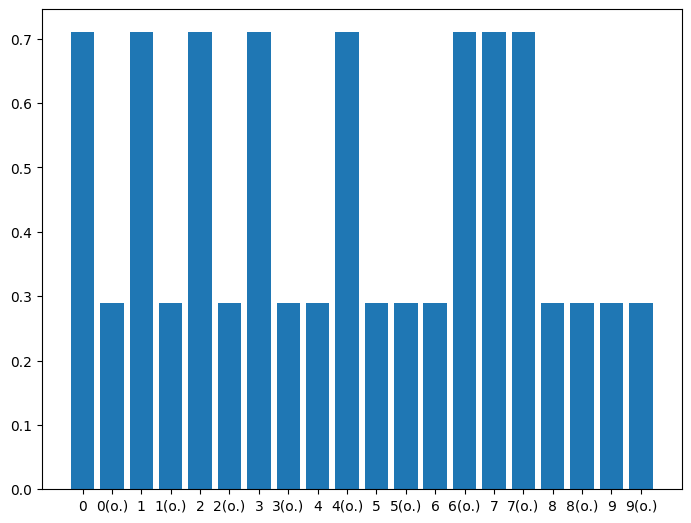

Dataset with id 1464


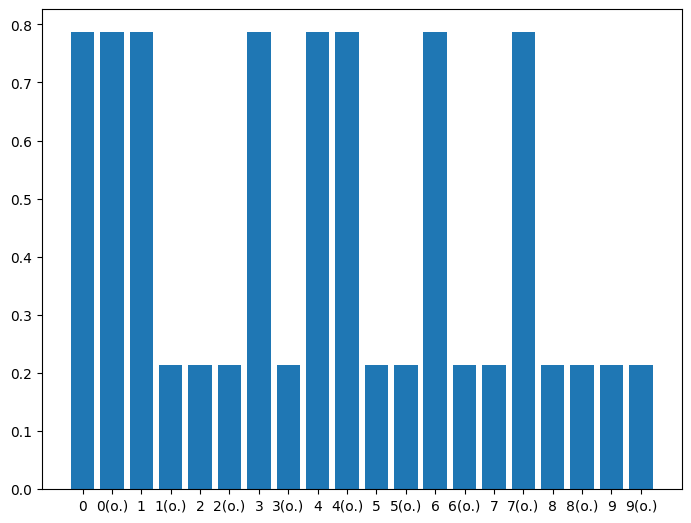

Dataset with id 334


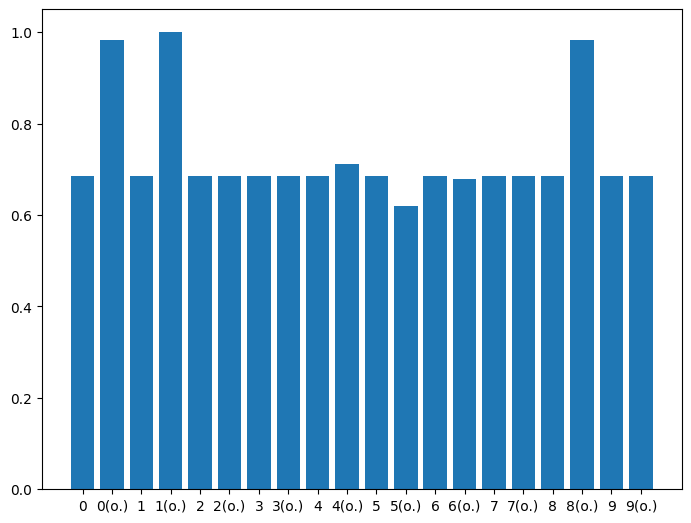

Dataset with id 333


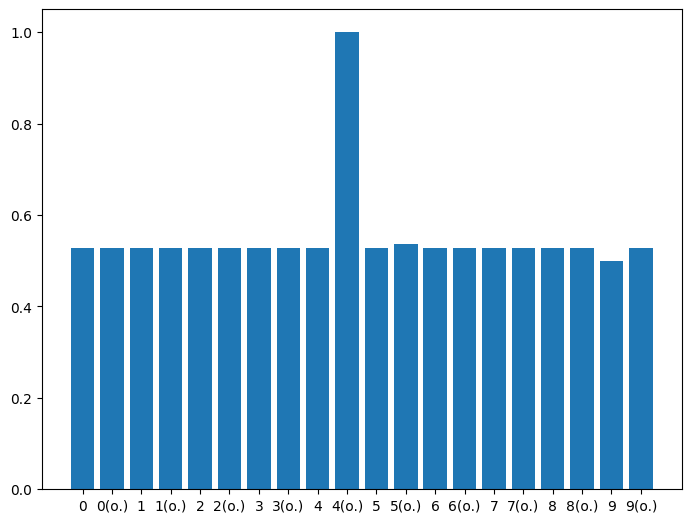

In [13]:

print(RESULTS_datasets)

for i in range(len(ids)):
    print("Dataset with id", ids[i])

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    opts = []
    k = 0
    for optimizer_name in available_optimizers:
        opts.append(str(k))
        opts.append(str(k) + "(o.)")
        k += 1

    ax.bar(opts, RESULTS_datasets[i])
    plt.show()

